# Style Transferring Of Image Using (CycleGAN)


CycleGANs are a novel approach for **translating an image from a source domain A to a target domain B**. One of the cool feature of CycleGANs is that it doesn’t **require paired training data** to produce stunning style transfer results.



***In many style transfer applications, paired data is a required for the training.***

<img src = "assets/paired.png" width="200" height = "200"/>  


***CycleGAN is doesn’t require paired data input to train a models.***
<img src = "assets/unpaired.png" height="400" width="400"/> 

### A CycleGAN tries to learn a Generator network, which, learns two mappings. CycleGANs train two Generators and two Discriminators networks. which differs from most of the GANs with a single Generator and Discriminator network.

### CycleGAN has two Generator networks
- Generator A: Learns a mapping G:X ->Y, where X is an image from the source domain A and Y is an image from the target domain B. It takes an image from the source domain A, and converts it into an image that is similar to an image from the target domain B. Basically, the aim of the network is to learn a mapping so that G(X) is similar to Y.
- Generator B: Learns a mapping F:Y->X, and then takes an image Y from the target domain B, and converts it into an image X that is similar to an image from the source domain A. Similarly, the aim of the network is to learn another mapping, so that F(G(X) is similar to X.


### CycleGAN has two Discriminator networks
- Discriminator A: The Discriminator A is to Discriminate between the images generated by the Generator network A, which are represented as G(X), and the real images from the source domain A, which are represented as X.
- Discriminator B: The Discriminator B is to Discriminate between the images generated by the Generator network B, which are represented as F(Y), and the real images from the source domain B, which are represented as Y.

<img src = "assets/desing.png" width="400" height = "300"/> 

#### The goal of CycleGANs is to learn how to map images from one domain A to another domain B. CycleGAN’s architecture diagram shows the use of two mapping functions G and F, and two Discriminators DX and DY.

- The discriminator DX is used to verify the images from domain A and the translated images F(y).
- The discriminator DY is used to verify the images from domain B and the translated images G(x).
- The CycleGANs use a cycle consistency loss for image translation. The cycle consistency loss is used to determine whether an image X from domain A can be recovered from the translated image.


**X to Y then reconstructed X CycleGAN’s Architecture**
<img src = "assets/x2y.png" width="400" height = "300"/> 
**Y to X then reconstructed Y CycleGAN Architecture**
<img src = "assets/y2x.png" width="400" height = "300"/> 

### Loss Functions
Like other GAN, CycleGANs also have a training objective function, which needs to minimize in training process. The loss function is a weighted sum of the following losses.
- Adversarial loss.
<img src = "assets/adversarial.png"/>
- Cycle consistency loss.
<img src = "assets/cycle.png"/>

### Total Objective loss
<img src = "assets/total.png"/>

#### Importing dependencies

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras

In [2]:
import tensorflow_datasets as tfds

import os
os.environ['TF_GPU_ALLOCATOR']='cuda_malloc_async'
import time
import matplotlib.pyplot as plt

AUTOTUNE = tf.data.AUTOTUNE

## loading+preprocessing data

In [4]:
#os.environ['CURL_CA_BUNDLE'] = "/etc/ssl/certs/ca-bundle.crt"
dataset, metadata = tfds.load('cycle_gan/horse2zebra',
                              with_info=True, as_supervised=True)

train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']

In [4]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [5]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [6]:
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [7]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [8]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [9]:
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [10]:
train_horses = train_horses.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_zebras = train_zebras.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_horses = test_horses.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_zebras = test_zebras.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [58]:
sample_horse = next(iter(train_horses))
sample_zebra = next(iter(train_zebras))

### Plotting Sample Images

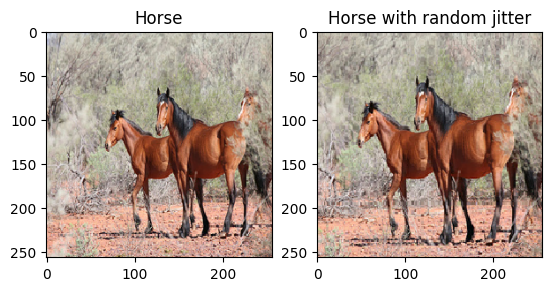

In [59]:
plt.subplot(121)
plt.title('Horse')
plt.imshow(sample_horse[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Horse with random jitter')
plt.imshow(random_jitter(sample_horse[0]) * 0.5 + 0.5)

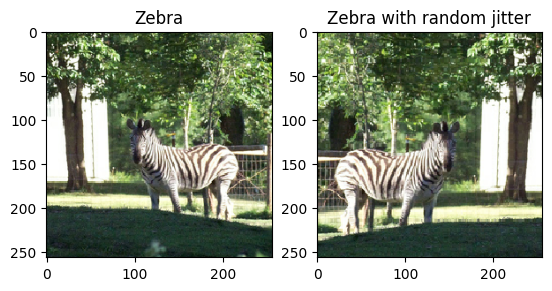

In [60]:
plt.subplot(121)
plt.title('Zebra')
plt.imshow(sample_zebra[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Zebra with random jitter')
plt.imshow(random_jitter(sample_zebra[0]) * 0.5 + 0.5)



### Defining discriminator architecture

In [61]:
def define_discriminator(image_shape):

    init = keras.initializers.RandomNormal(stddev=0.02)

    in_image = keras.Input(shape=image_shape)

    d= keras.layers.Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    d = keras.layers.LeakyReLU(alpha=0.2)(d)

    d = keras.layers.Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d =tfa.layers.InstanceNormalization(axis=-1)(d)
    d = keras.layers.LeakyReLU(alpha=0.2)(d)
    
    # C256
    d = keras.layers.Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = tfa.layers.InstanceNormalization(axis=-1)(d)
    d = keras.layers.LeakyReLU(alpha=0.2)(d)
    
    # C512
    d = keras.layers.Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = tfa.layers.InstanceNormalization(axis=-1)(d)
    d = keras.layers.LeakyReLU(alpha=0.2)(d)
    
    # second last output layer
    d = keras.layers.Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = tfa.layers.InstanceNormalization(axis=-1)(d)
    d = keras.layers.LeakyReLU(alpha=0.2)(d)
    

    patch_out = keras.layers.Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)

    model = keras.models.Model(in_image, patch_out)

    model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss_weights=[0.5])
    return model

In [62]:
image_shape=(256,256,3)
with tf.device('/gpu:1') :
    disc_x=define_discriminator(image_shape)
    disc_y=define_discriminator(image_shape)
disc_x.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_56 (Conv2D)          (None, 128, 128, 64)      3136      
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 128, 128, 64)      0         
                                                                 
 conv2d_57 (Conv2D)          (None, 64, 64, 128)       131200    
                                                                 
 instance_normalization_56 (  (None, 64, 64, 128)      256       
 InstanceNormalization)                                          
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 64, 64, 128)       0         
                                                           

### Resnet block for generator

In [63]:
def resnet_block(n_filters, input_layer):
    # weight initialization
    init = keras.initializers.RandomNormal(stddev=0.02)
    
    # first layer convolutional layer
    g = keras.layers.Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
    g = tfa.layers.InstanceNormalization(axis=-1)(g)
    g = keras.layers.Activation('relu')(g)
    # second convolutional layer
    g = keras.layers.Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
    g = tfa.layers.InstanceNormalization(axis=-1)(g)
    # concatenate merge channel-wise with input layer
    g = keras.layers.Concatenate()([g, input_layer])
    return g

### Defining generator architecture

In [64]:
def define_generator(image_shape, n_resnet=9):
    # weight initialization
    init = keras.initializers.RandomNormal(stddev=0.02)
    # image input
    in_image = keras.Input(shape=image_shape)

    g = keras.layers.Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
    g = tfa.layers.InstanceNormalization(axis=-1)(g)
    g = keras.layers.Activation('relu')(g)
    # d128
    g = keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = tfa.layers.InstanceNormalization(axis=-1)(g)
    g = keras.layers.Activation('relu')(g)
    # d256
    g = keras.layers.Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = tfa.layers.InstanceNormalization(axis=-1)(g)
    g = keras.layers.Activation('relu')(g)
    # R256
    for _ in range(n_resnet):
        g = resnet_block(256, g)
    # u128
    g = keras.layers.Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = tfa.layers.InstanceNormalization(axis=-1)(g)
    g = keras.layers.Activation('relu')(g)
    # u64
    g = keras.layers.Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = tfa.layers.InstanceNormalization(axis=-1)(g)
    g = keras.layers.Activation('relu')(g)

    g = keras.layers.Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
    g = tfa.layers.InstanceNormalization(axis=-1)(g)
    out_image = keras.layers.Activation('tanh')(g)
    # define model
    model = keras.models.Model(in_image, out_image)
    return model

In [65]:
with tf.device('/gpu:1') :
    gen_g=define_generator(image_shape, 9)
    gen_f=define_generator(image_shape, 9)

In [66]:
gen_g.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_68 (Conv2D)             (None, 256, 256, 64  9472        ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 instance_normalization_64 (Ins  (None, 256, 256, 64  128        ['conv2d_68[0][0]']              
 tanceNormalization)            )                                                           

### Plotting Initial predictions of both generators

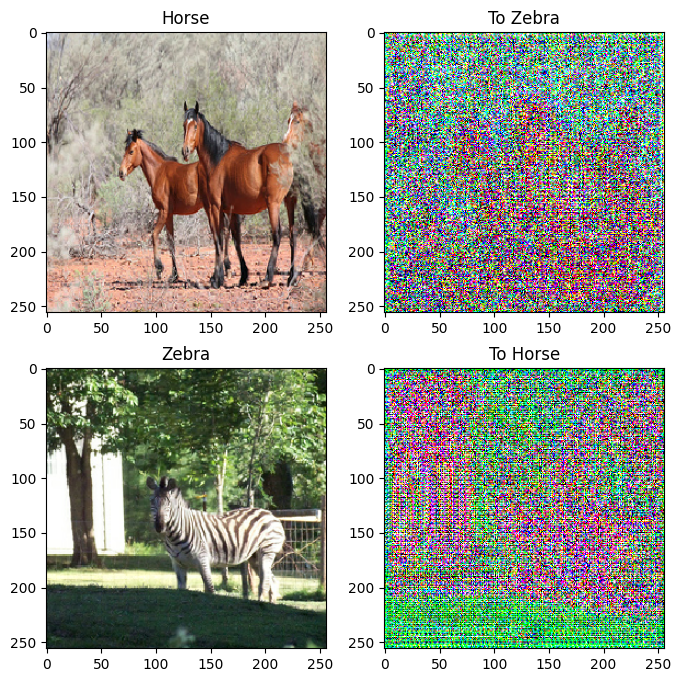

In [67]:
with tf.device('/gpu:1') :
    to_zebra = gen_g(sample_horse)
    to_horse = gen_f(sample_zebra)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_horse, to_zebra, sample_zebra, to_horse]
title = ['Horse', 'To Zebra', 'Zebra', 'To Horse']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

### Plottinig initial results of both discriminators

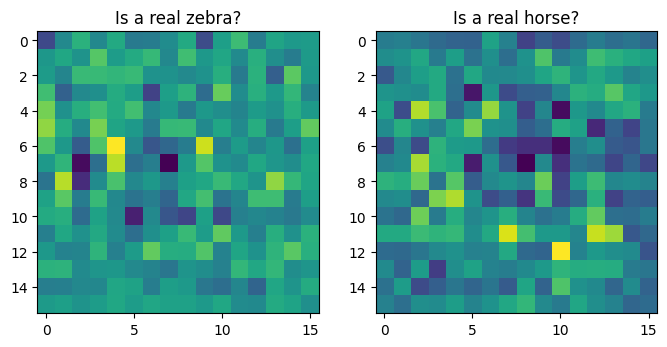

In [68]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real zebra?')
with tf.device('/gpu:1') :
    plt.imshow(disc_y(sample_zebra)[0, ..., -1])

plt.subplot(122)
plt.title('Is a real horse?')
with tf.device('/gpu:1') :
    plt.imshow(disc_x(sample_horse)[0, ..., -1])

plt.show()

In [69]:
LAMBDA = 10

### Defining loss functions

In [70]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [71]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [72]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [73]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [74]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss


#### Define optimizer

In [75]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

#### Utility funtion for saving and restoroing checkpointss

In [76]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(gen_g=gen_g,
                           gen_f=gen_f,
                           disc_x=disc_x,
                           disc_y=disc_y,
                           gen_g_optimizer=generator_g_optimizer,
                           gen_f_optimizer=generator_f_optimizer,
                           disc_x_optimizer=discriminator_x_optimizer,
                           discr_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [77]:
EPOCHS = 40

#### Utility funtion for generatinig images

In [78]:
def generate_images(model, test_input):
    
      prediction = model(test_input)

      plt.figure(figsize=(12, 12))

      display_list = [test_input[0], prediction[0]]
      title = ['Input Image', 'Predicted Image']

      for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
      plt.show()

### Train step for each batches

We generate the required images using current weights of generator, compare it, caclulate loss, and then perform backporpagation to update the generator and discriminator weights

In [79]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = gen_g(real_x, training=True)
    cycled_x = gen_f(fake_y, training=True)

    fake_x = gen_f(real_y, training=True)
    cycled_y = gen_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = gen_f(real_x, training=True)
    same_y = gen_g(real_y, training=True)

    disc_real_x = disc_x(real_x, training=True)
    disc_real_y = disc_y(real_y, training=True)

    disc_fake_x = disc_x(fake_x, training=True)
    disc_fake_y = disc_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        gen_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        gen_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            disc_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            disc_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            gen_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            gen_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                disc_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                disc_y.trainable_variables))

### Main feedback loop

In [ ]:
with tf.device('/gpu:1') :
    for epoch in range(EPOCHS):
      start = time.time()

      n = 0
      for image_x, image_y in tf.data.Dataset.zip((train_horses, train_zebras)):
        train_step(image_x, image_y)
        if n % 10 == 0:
          print ('.', end='')
        n += 1

      #clear_output(wait=True)
      # Using a consistent image (sample_horse) so that the progress of the model
      # is clearly visible.
      generate_images(gen_g, sample_horse)

      if (epoch + 1) % 2 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                             ckpt_save_path))

      print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                          time.time()-start))

### Plotting result images

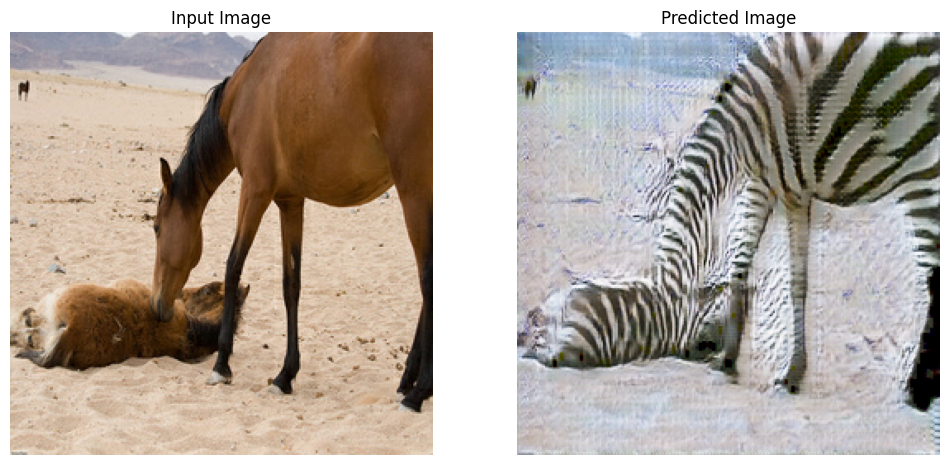

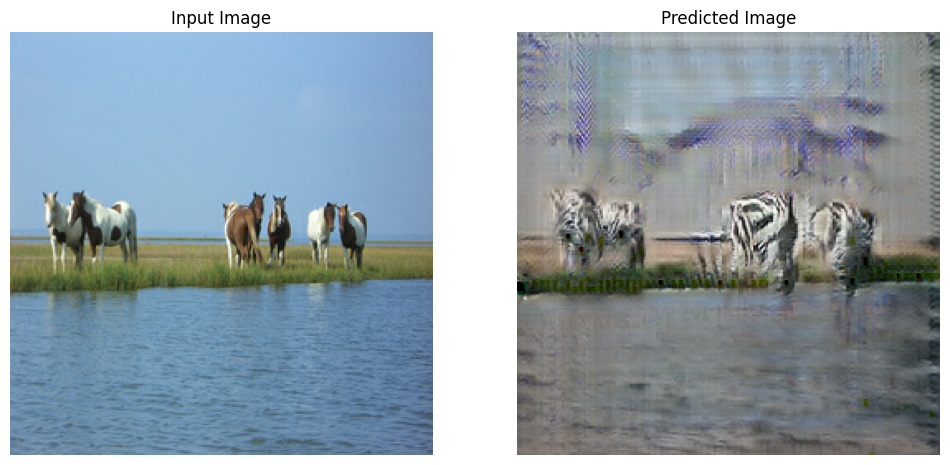

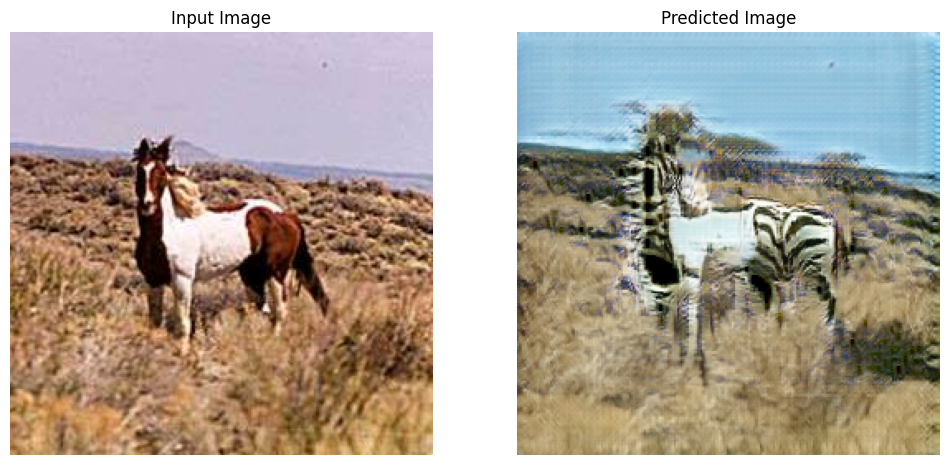

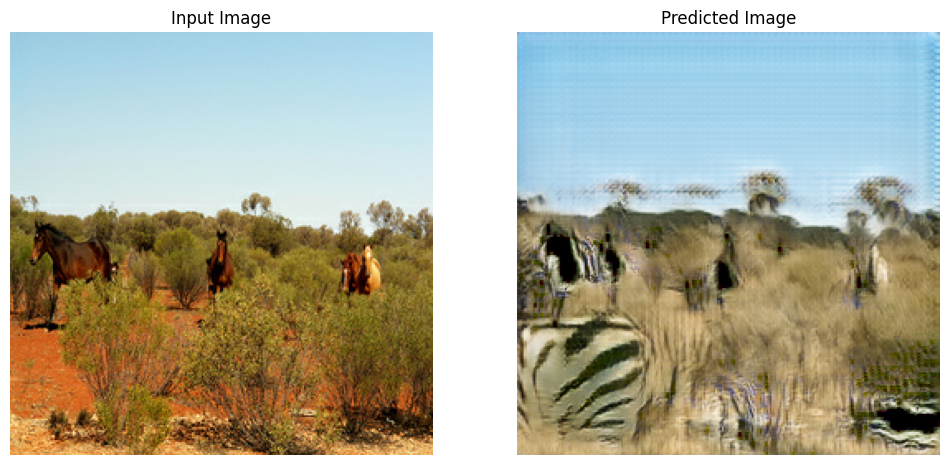

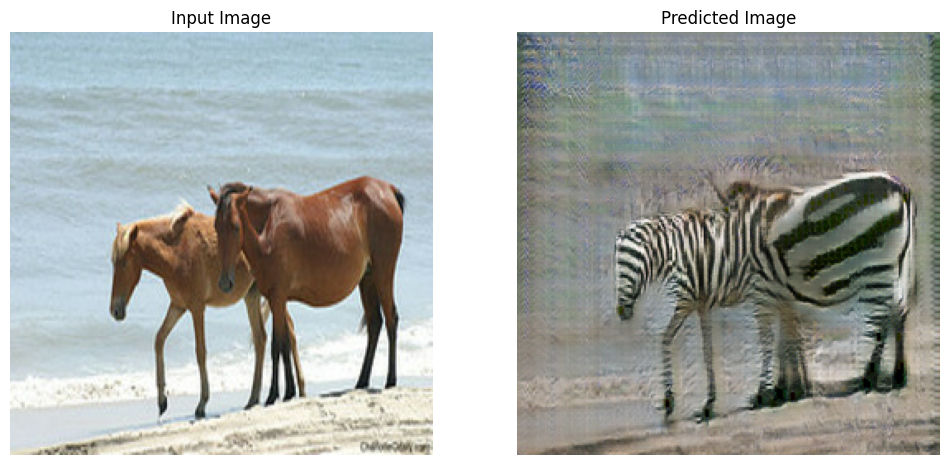

In [82]:
with tf.device('/gpu:1') :
    for inp in test_horses.take(5):
      generate_images(gen_g, inp)